<a href="https://colab.research.google.com/github/Bk073/VIC_Reg-Implementation/blob/main/VICReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference:


*   https://arxiv.org/abs/2105.04906 (VICReg: Variance-Invariance-Covariance Regularization for Self-Supervised Learning)

In [ ]:
!pip install -U tensorflow-addons

## Import

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Layer, Flatten, ReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model, Sequential
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import numpy as np
from tqdm import tqdm
import os
import random

import matplotlib.pyplot as plt

## Preparing dataset


*   For now I have used dataset from tensorflow
*   However to evaluate model with the paper, I will be using Imagenet dataset with 2 classes because the memory capacity will not be sufficient if taking all classes 



In [ ]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:1%]", "train[85%:]"]
)

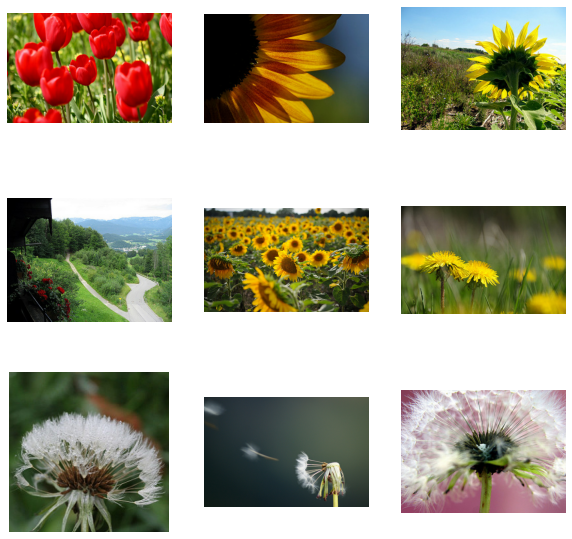

In [ ]:
# checking few example

plt.figure(figsize=(10,10))
for i, image in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image['image'])
  plt.axis("off")

## Augmentation


*   For now simple augmentation has been implemented to set up the pipeline

* VigReg paper only highlights the loss function. But the paper haven't explored much in data augmentation and have used multiple augmentation such as random horizontal flip, color jittering of brightness, blurring, etc
* Data augmentation plays major role in invariant learning
    * TODO:
        * **Explore and test data augmentation technique and other augmentation characteristics to learn invariant representation**



In [ ]:
# Simple augmentation
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)


def custom_augment(image):
    image = image['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))

    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    return image

In [ ]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

dataset_one = (
    train_ds
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

dataset_two = (
    train_ds
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

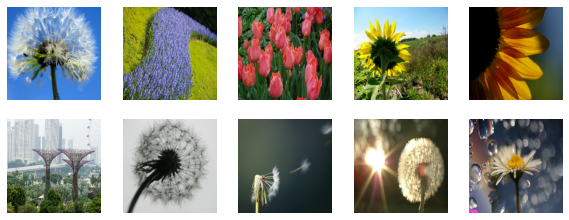

In [ ]:
sample_images = next(iter(dataset_one))

plt.figure(figsize=(10, 10))
for n in range(10):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()



## Model building


*   Original paper has used Resnet50, and it the popular architecture widely used in SSL 
*   But testing Resnet50 on local machine and google colab with GPU has computational expenses even by using low batch size and the paper has trained the model in distributed manner with multiple GPUs
*   To handle this problem, I have writted Resnet-18 and it can easily be trained on google colab with higher batch size


In [ ]:
# Implementation of Resnet basic block which consist of two convolutional layer and the size is decreased after 2 such resnet block

class ResnetBlock(Layer):
  def __init__(self, channels: int, down_sample=False):
    super().__init__()
    self.channels = channels
    self.down_sample = down_sample
    self.strides = [2, 1] if down_sample else [1,1]
    kernel_size = (3,3)
    
    self.conv_1 = Conv2D(self.channels, strides=self.strides[0], kernel_size=kernel_size, padding='same')
    self.bn_1 = BatchNormalization()
    self.conv_2 = Conv2D(self.channels, strides=self.strides[1], kernel_size=kernel_size, padding='same')
    self.bn_2 = BatchNormalization()
    self.merge = Add()

    if self.down_sample:
      self.res_conv = Conv2D(self.channels, strides=2, kernel_size=(1,1), padding='same')
      self.res_bn = BatchNormalization()
    
  def call(self, inputs):
    r = inputs
    x = self.conv_1(inputs)
    x = self.bn_1(x)
    x = tf.nn.relu(x)
    x = self.conv_2(x)
    x = self.bn_2(x)

    if self.down_sample:
      r = self.res_conv(r)
      r = self.res_bn(r)
    
    x = self.merge([x,r])
    out = tf.nn.relu(x)

    return out

In [ ]:
# Compiling the basic resnet block into Resnet-18, which consist of 18 trainable layers

class ResNet18(Model):
  def __init__(self, num_classes, include_top=True, **kwargs):
    super().__init__(**kwargs)
    self.conv_1 = Conv2D(64, (7,7), strides=2, padding='same')
    self.init_bn = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')
    self.res_1_1 = ResnetBlock(64)
    self.res_1_2 = ResnetBlock(64)
    self.res_2_1 = ResnetBlock(128, down_sample=True)
    self.res_2_2 = ResnetBlock(128)
    self.res_3_1 = ResnetBlock(256, down_sample=True)
    self.res_3_2 = ResnetBlock(256)
    self.res_4_1 = ResnetBlock(512, down_sample=True)
    self.res_4_2 = ResnetBlock(512)
    self.avg_pool = GlobalAveragePooling2D()
    self.flat = Flatten()
    self.fc = Dense(num_classes, activation='softmax')
    self.include_top = include_top

  def call(self, inputs):
    out = self.conv_1(inputs)
    out = self.init_bn(out)
    out = tf.nn.relu(out)
    out = self.pool_2(out)
    for res_blk in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
      out = res_blk(out)
    out = self.avg_pool(out)
    if self.include_top:
      out = self.flat(out)
      out = self.fc(out)
    return out

In [ ]:
# model_resnet = ResNet18(10, include_top=False)
# model_resnet.build(input_shape=(64,224,224,3))
# model_resnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
# model_resnet.summary()

In [ ]:
# model_resnet.layers[:-2]

### VICReg implementation using Resnet-18

* For now, I have used low dimensional representation due to complexity, will use higher dimension for feature representation

In [ ]:
class VICReg(Model):
  def __init__(self):
    super(VICReg, self).__init__()
    # previously tested Resnet-50
    
    # self.base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    self.base_model = ResNet18(10, include_top=False)
    # for layer in self.base_model.layers:
    #   layer.trainable = False
    # for layer in self.base_model.layers[:2]:
    #   layer.trainable=True
    # self.base_model.trainable = True
    self.encoder = Sequential(
        [
         self.base_model,
         Flatten()
        ]
    )
# flatten*10+200
    self.expander = Sequential(
        [
         Dense(10),
         BatchNormalization(),
         ReLU(),
         Dense(10),
         BatchNormalization(),
         ReLU(),
         Dense(10)
        ]
    )
  def call(self, x):
    _repr = self.encoder(x)
    _embeds = self.expander(_repr)
    return _embeds

In [ ]:
model = VICReg()

In [ ]:
# for layer in model.encoder:
  # layer.trainable=False
# model.encoder.trainable=False

# for layer in model.encoder[0].layers[:2]:
#       layer.trainable=True

In [ ]:
model.build(input_shape=(None, 224,224,3))
model.summary()

Model: "vic_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net18 (ResNet18)        (None, 512)               11190912  
                                                                 
 sequential (Sequential)     (None, 512)               11190912  
                                                                 
 sequential_1 (Sequential)   (None, 10)                5430      
                                                                 
Total params: 11,196,342
Trainable params: 11,186,702
Non-trainable params: 9,640
_________________________________________________________________


## Implementing VICReg's loss function

*   Invariance is measured using mean squared loss function
*   Variance and Covariance acts as a regularizer
*   Covariance term is modified from Barlow Twins where they have used cross-correlation of 2 branches together. But this paper have used covariance and variance independently in 2 branches




In [ ]:

sim_loss = tf.keras.losses.MeanSquaredError()
  
def variance_loss(z_a, z_b):
  std_z_a = tf.math.reduce_std(z_a, axis=0)
  std_z_b = tf.math.reduce_std(z_b, axis=0)

  std_loss = tf.reduce_mean(tf.nn.relu(1-std_z_a) + tf.nn.relu(1-std_z_b))
  return std_loss

def off_diagonal(x):
  n, m = x.shape
  assert n == m
  return tf.reshape((tf.reshape(tf.reshape(x, [-1])[:-1], shape=(n - 1, n + 1))[:, 1:]), [-1])

def cov(x):
  x = tf.cast(x, tf.float32)
  x = x - tf.math.reduce_mean(x, axis=0)
  cov_ = tf.linalg.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0]-1, tf.float32)
  return cov_

def covariance_loss(z_a, z_b):
  D = tf.cast(tf.shape(z_a)[1], tf.float32)
  import pdb
  # pdb.set_trace()
  cov_z_a = cov(z_a)
  cov_z_b = cov(z_b)
  cov_loss = tf.math.pow(off_diagonal(cov_z_a), 2) / D + tf.math.pow(off_diagonal(cov_z_b), 2) / D
  return cov_loss

## Training


*   Custom training loop using gradient tape


In [ ]:
# training

In [ ]:
def train_step(ds_one, ds_two, model, optimizer):
  with tf.GradientTape() as tape:
    z_a, z_b = model(ds_one), model(ds_two)
    import pdb
    # pdb.set_trace()
    sim_loss_ = tf.cast(sim_loss(z_a, z_b), tf.float32)
    var_loss = tf.cast(variance_loss(z_a, z_b), tf.float32)
    # pdb.set_trace()
    cov_loss = tf.cast(covariance_loss(z_a, z_b), tf.float32)

    loss = 10 * sim_loss_ + 10 * var_loss + 1 * cov_loss
  
  learnable_params = model.trainable_variables
  gradients = tape.gradient(loss, learnable_params)
  optimizer.apply_gradients(zip(gradients, learnable_params))
  return loss


In [ ]:
def train_vigreg(model, dataset_one, dataset_two, optimizer, epochs=100):
  step_wise_loss = []
  epoch_wise_loss = []

  for epoch in tqdm(range(epochs)):
    for ds_one, ds_two in zip(dataset_one, dataset_two):
      loss = train_step(ds_one, ds_two, model, optimizer)
      step_wise_loss.append(loss)

    epoch_wise_loss.append(np.mean(step_wise_loss))
    
    if epoch % 10 == 0:
      print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

  return epoch_wise_loss, model

In [ ]:
learning_rate = 0.001
optimizer = tfa.optimizers.LAMB(learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = tf.keras.optimizers.SGD()
epochs = 100

loss, model_ = train_vigreg(model, dataset_one, dataset_two, optimizer, epochs)

  1%|          | 1/100 [00:05<09:22,  5.68s/it]

epoch: 1 loss: 19.635


 11%|█         | 11/100 [00:46<06:20,  4.27s/it]

epoch: 11 loss: 17.520


 21%|██        | 21/100 [01:07<02:16,  1.73s/it]

epoch: 21 loss: 17.215


 31%|███       | 31/100 [01:27<02:45,  2.40s/it]

epoch: 31 loss: 16.961


 41%|████      | 41/100 [01:56<02:01,  2.05s/it]

epoch: 41 loss: 16.851


 51%|█████     | 51/100 [02:14<01:36,  1.97s/it]

epoch: 51 loss: 16.766


 61%|██████    | 61/100 [02:32<01:09,  1.78s/it]

epoch: 61 loss: 16.684


 71%|███████   | 71/100 [02:58<01:27,  3.02s/it]

epoch: 71 loss: 16.652


 81%|████████  | 81/100 [03:16<00:37,  1.99s/it]

epoch: 81 loss: 16.546


 91%|█████████ | 91/100 [03:37<00:22,  2.47s/it]

epoch: 91 loss: 16.538


100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


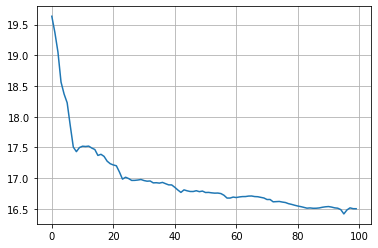

In [ ]:
plt.plot(loss)
plt.grid()
plt.show()

## Saving model

In [ ]:
model_.save_weights('checkpoint_1')

## Evaluation


*   Most of the SSL methods are evaluated by adding linear classifier model on top of the frozen representation of the SSL architecture
*   Here is the simple classifier to evaluated the model, currently the VIGReg model is not trained well so the classifier is not well



In [ ]:
# Evaluation

In [ ]:
base_model = VICReg()
base_model.load_weights('checkpoint_1')
base_model.encoder.trainable = False
base_model = base_model.encoder

In [ ]:
# base_model.layers[:2]

In [ ]:
train_ds, valid_ds = tfds.load(
    'tf_flowers',
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE=128

In [ ]:
def resize(img, label):
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, (224,224))
  return (img, label)

In [ ]:
train_ds = train_ds.map(resize, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
valid_ds = valid_ds.map(resize, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

In [ ]:
class ClassificationModel(Model):
  def __init__(self, base_model):
    super(ClassificationModel, self).__init__()
    # self.base_model = VICReg()
    self.base_model = base_model
    self.dense_1 = Dense(10, activation='relu')
    self.out = Dense(5, activation='softmax')
  
  def call(self, x):
    x = self.base_model(x)
    x = self.dense_1(x)
    out = self.out(x)

In [ ]:
eval_model = ClassificationModel(base_model)
eval_model.build(input_shape=(None, 224,224,3))
eval_model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 512)               11190912  
                                                                 
 dense_8 (Dense)             multiple                  5130      
                                                                 
 dense_9 (Dense)             multiple                  55        
                                                                 
Total params: 11,196,097
Trainable params: 5,185
Non-trainable params: 11,190,912
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

history = model.fit(train_ds, validation_data=valid_ds, epochs=10)


Epoch 1/10
25/25 [==============================] - 29s 864ms/step - loss: 9.1467 - accuracy: 0.1587 - val_loss: 11.1476 - val_accuracy: 0.0200
Epoch 2/10
25/25 [==============================] - 19s 747ms/step - loss: 8.5602 - accuracy: 0.2487 - val_loss: 11.4621 - val_accuracy: 0.1855
Epoch 3/10
25/25 [==============================] - 19s 752ms/step - loss: 8.0481 - accuracy: 0.1897 - val_loss: 11.0918 - val_accuracy: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 19s 745ms/step - loss: 6.2420 - accuracy: 0.2522 - val_loss: 9.7956 - val_accuracy: 0.1927
Epoch 5/10
25/25 [==============================] - 19s 746ms/step - loss: 5.8841 - accuracy: 0.3067 - val_loss: 8.4150 - val_accuracy: 0.2545
Epoch 6/10
25/25 [==============================] - 19s 746ms/step - loss: 5.5521 - accuracy: 0.3205 - val_loss: 9.4051 - val_accuracy: 0.1818
Epoch 7/10
25/25 [==============================] - 19s 754ms/step - loss: 5.4562 - accuracy: 0.3119 - val_loss: 7.4801 - val_accuracy:

In [ ]:
def plot_(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

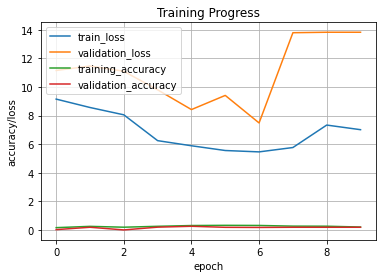

In [ ]:
plot_(history)

# TODO

* augmentation and strong regularization still causes collapse problem and occupy lower-dimensional space
* TODO: **handle collapse problem and help the model to expand the entire feature space**
* analyse results on Imagenet(2 class) and compare results
